# DQN Tutorial

[Tutorial Page](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
sys.path.append("/Users/toshi_pro/Documents/github-sub/machine-learning")
import flowdata
import flowenv

# env = gym.make("CartPole-v1")

raw_data_train, raw_data_test = flowdata.flow_data.using_data()

env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


In [2]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
# Training

BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n   # output size
state, info = env.reset()
n_observation = len(state)

policy_net = DQN(n_observation, n_actions).to(device)
target_net = DQN(n_observation, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_rewards = []
episode_confusions = {
    "TP": [],
    "TN": [],
    "FP": [],
    "FN": []
}
episode_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

def plot_rewards(show_result=False):
    plt.figure(1)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    
    plt.xlabel("Episode")
    plt.ylabel("reward")
    plt.plot(episode_rewards)
    
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_confusions(show_result=False):
    plt.figure(figsize=(16, 4))

    plt.plot(episode_confusions["TP"], label="TP")
    plt.plot(episode_confusions["TN"], label="TN", color="green")
    plt.plot(episode_confusions["FP"], label="FP", color="red")
    plt.plot(episode_confusions["FN"], label="FN", color="black")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_metrics(show_result=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(episode_metrics["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(episode_metrics["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(episode_metrics["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(episode_metrics["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(episode_metrics["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def calcurate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr


In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transactions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transactions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    

Complete


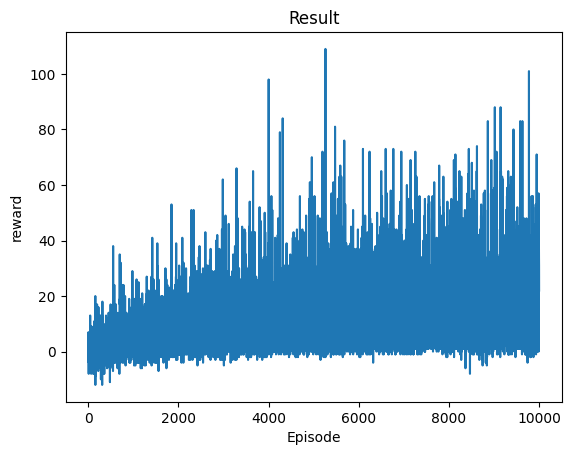

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

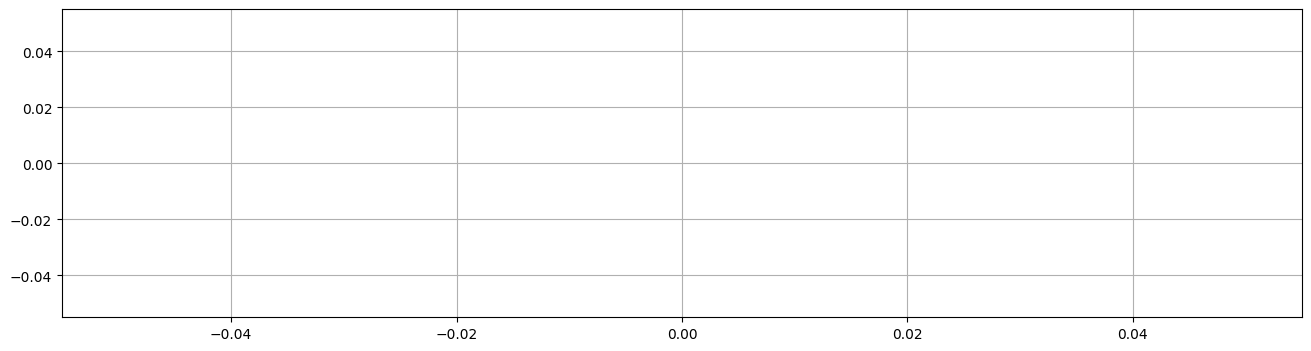

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

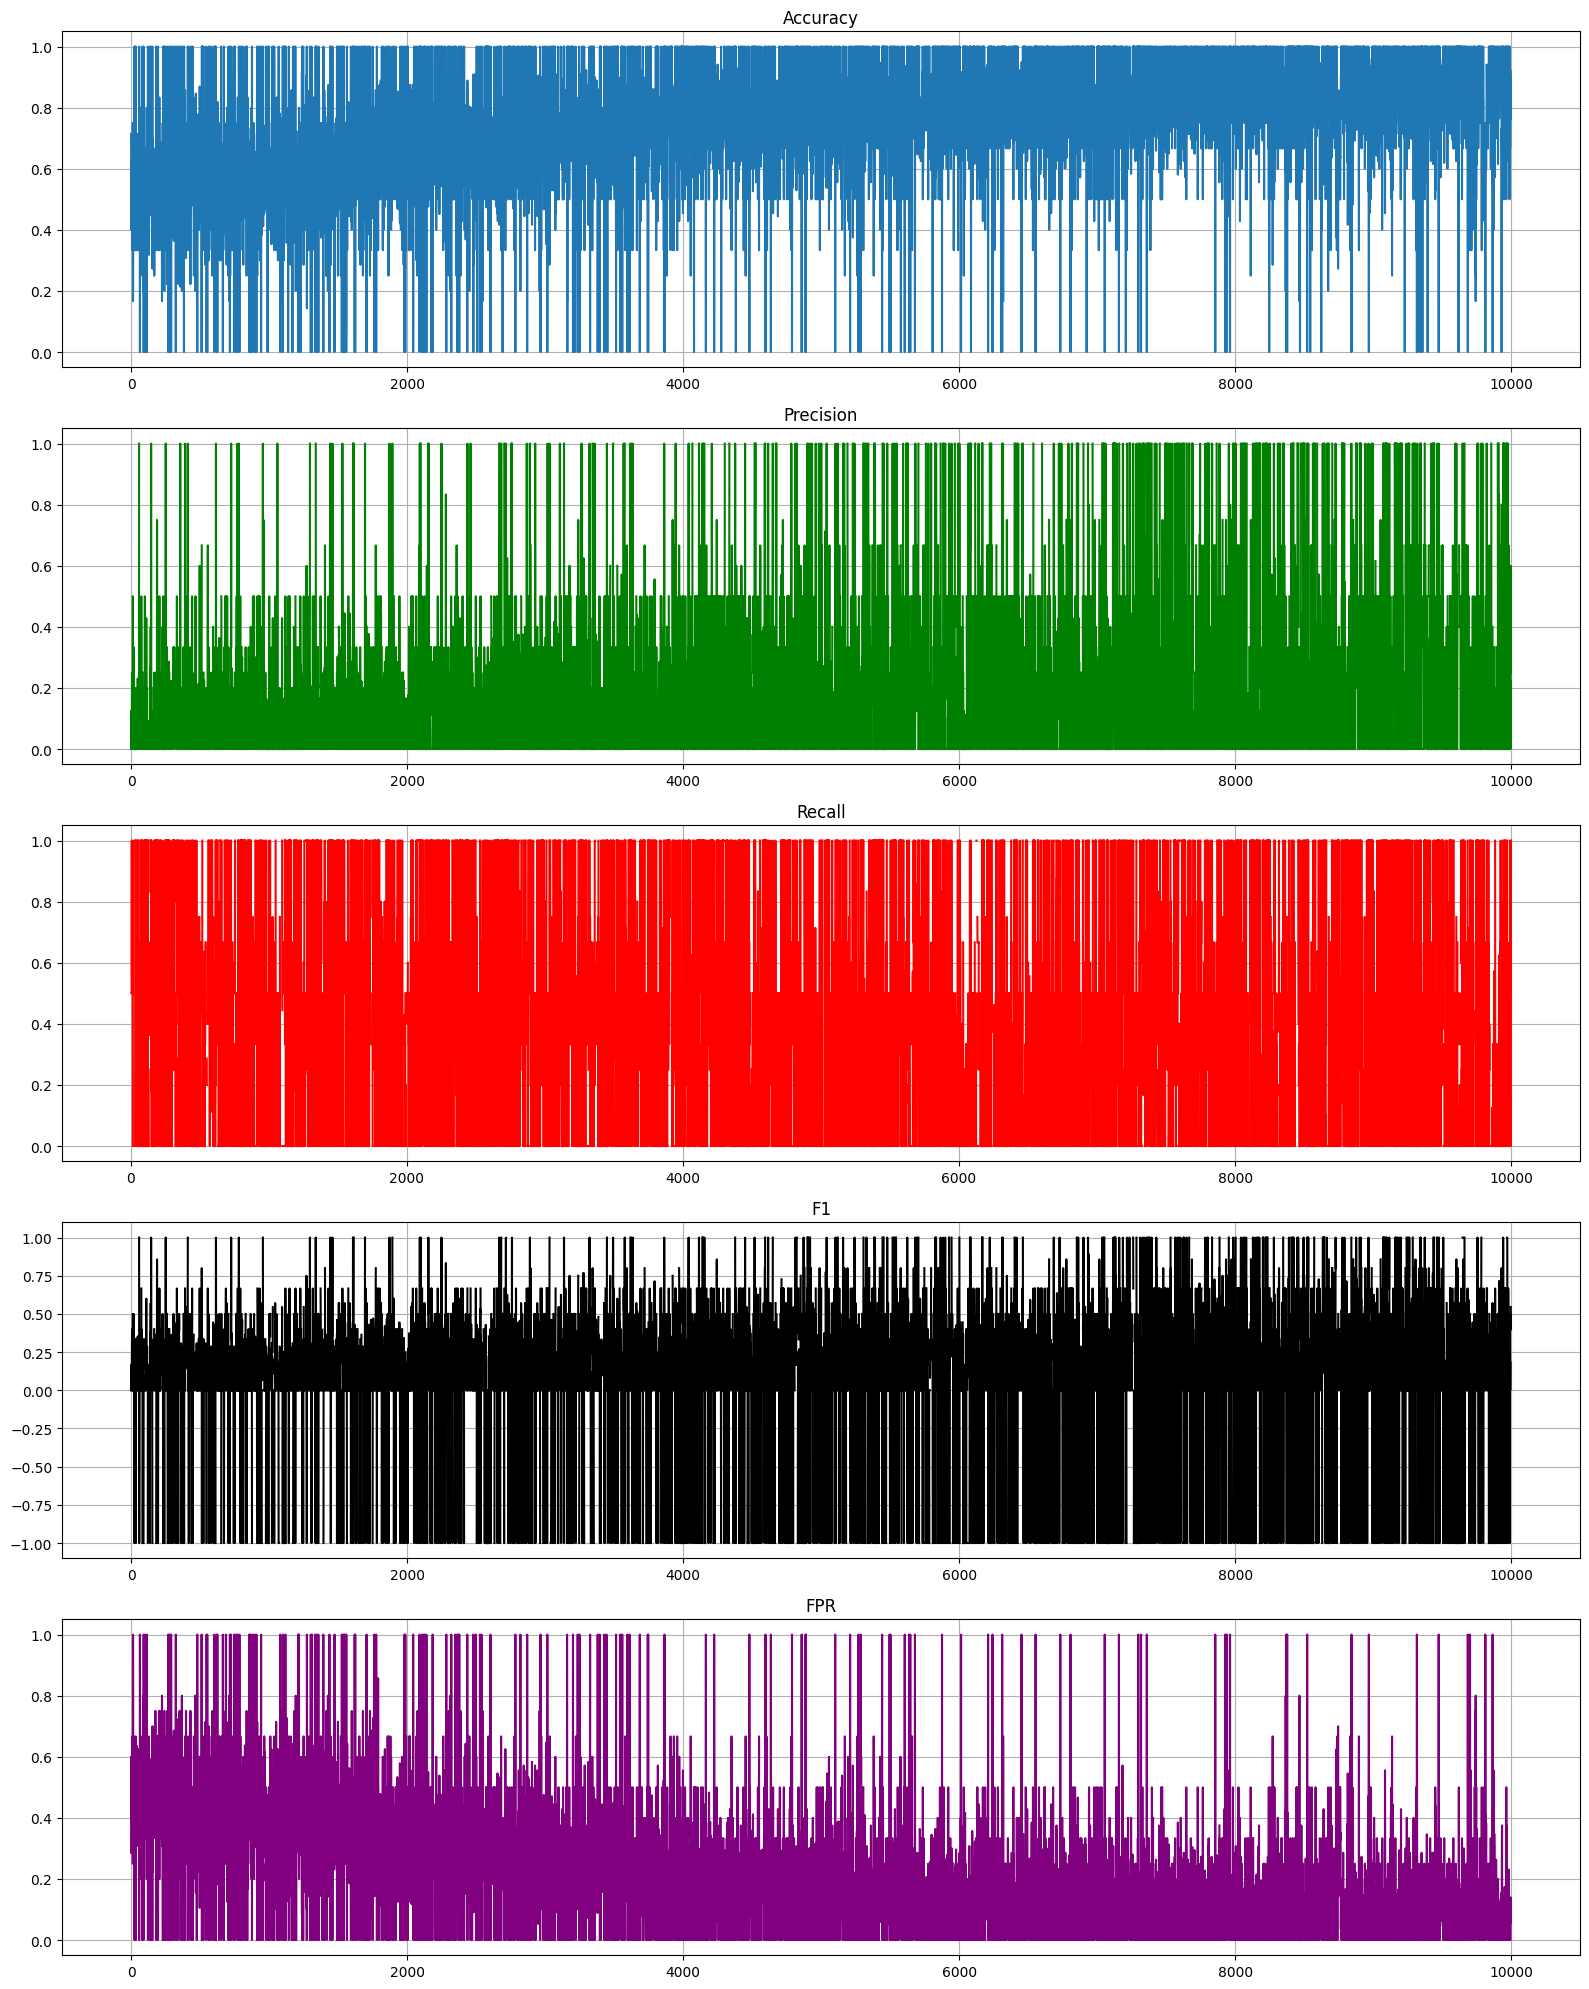

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    print("Using GPU")
    num_episodes = 10000
else:
    print("Using CPU")
    num_episodes = 100

for i_episode in range(num_episodes):
    total_reward = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    confusions_count = {
        "TP": 0,
        "TN": 0,
        "FP": 0,
        "FN": 0
    }
    loop = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        confusions_count[info["confusion"]] += 1

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        memory.push(state, action, next_state, reward)
        total_reward += reward.item()

        state = next_state

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(total_reward)
            # plot_rewards()
            loop = t + 1
            break
    ac, pr, re, f1, fp = calcurate_metrics(
        confusions_count["TP"],
        confusions_count["TN"],
        confusions_count["FP"],
        confusions_count["FN"]
    )
    episode_metrics["accuracy"].append(ac)
    episode_metrics["precision"].append(pr)
    episode_metrics["recall"].append(re)
    episode_metrics["f1"].append(f1)
    episode_metrics["fpr"].append(fp)

    # for key in confusions_count:
    #     episode_confusions[key].append(confusions_count[key] / loop)
    # plot_confusions()
    plot_metrics()

print("Complete")
plot_rewards(show_result=True)
plot_confusions(show_result=True)
plot_metrics(show_result=True)
plt.ioff()
plt.show()

torch.save(policy_net.state_dict(), "dqn_no2.pth")
# tp: blue, tn: green, fp: red, fn: black
    

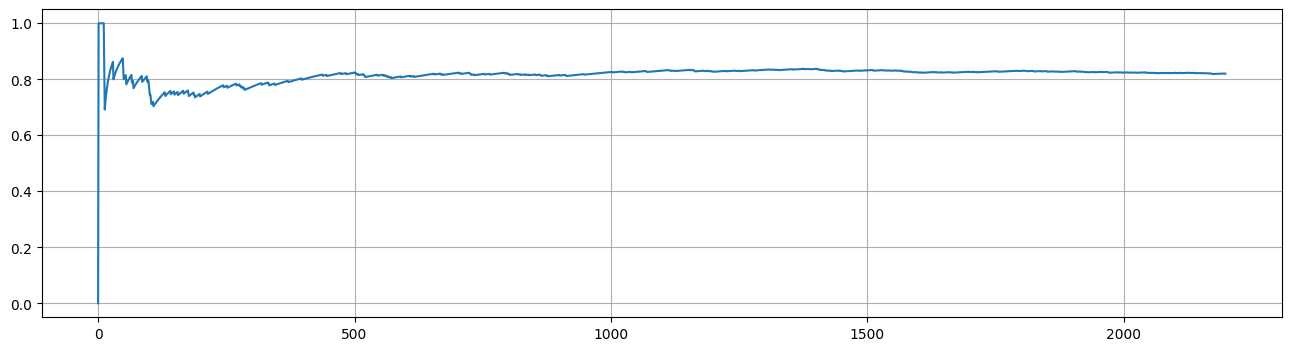

In [11]:
means = [0]
for i in range(1, len(episode_rewards)):
    means.append(np.mean(episode_rewards[0:i]))

torch.save(policy_net.state_dict(), "dqn_no2_10000.pth")

plt.figure(figsize=(16, 4))
plt.plot(means)
plt.grid()
plt.show()

In [10]:
trained_net = DQN(n_observation, n_actions).to(device)
trained_net.load_state_dict(torch.load("dqn_no2.pth"))
trained_net.eval()

num_loop = len(raw_data_test) - 1
episode_rewards = []
state, info = test_env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
confusion = [0, 0, 0, 0]

for i in range(num_loop):
    with torch.no_grad():
        action = trained_net(state).max(1).indices.view(1, 1)

    next_state, reward, terminated, truncated, info = test_env.step(action.item())
    done = terminated or truncated

    next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

    state = next_state
    confusion[info["value"]] += 1
    # print(f"action: {action.item()}, reward: {reward:+1}, info: {info}")

    episode_rewards.append(reward)

print(confusion)
#plt.figure(figsize=(16, 4))
#plt.plot(episode_rewards)
#plt.grid()
#plt.show()

/var/folders/d3/7m94kh9j1xg5sc7cx2lk48t00000gn/T/ipykernel_12292/1209100989.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_net.load_state_dict(torch.load("dqn_n

0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:True => reward: -1, confusion: FN
0:True => reward: -1, confusion: FN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confusion: TN
0:False => reward: 1, confus